# **U-NET MULTI CLASS SEGMENTATION MODEL**

In [ ]:
%%capture
!pip install gdown xarray[complete]
!apt-get install tree
file_id = '10yslT_c6jQN7FmrRXvRXjWFTju75iWa5'
!gdown --id $file_id
!unzip -o Dataset.zip -d Dataset

The dataset folder contains
1. Folder `lc_imgs` - This folder contains 10000 `netcdf` files containing high resolution imagery.
2. `class_dict.json` - This file contains the mapping of segmentation values for the landcover maps

In [ ]:
!tree Dataset --filelimit=5

Dataset
├── class_dict.json
└── lc_imgs  [10000 entries exceeds filelimit, not opening dir]

1 directory, 1 file


In [ ]:
import xarray as xr

sample_img = xr.open_dataset('./Dataset/lc_imgs/1200.nc')

sample_img

img_data = sample_img.to_array().values


In [ ]:
# to access particular data variables as numpy array
sample_img['lc'].values

# to access the full image data as numpy arrray
sample_img.to_array().values

array([[[ 83.,  91.,  89., ...,  74.,  99., 100.],
        [102., 100., 104., ...,  80.,  74.,  90.],
        [ 93.,  91., 107., ...,  69.,  63.,  66.],
        ...,
        [100.,  82.,  78., ...,  75.,  83., 106.],
        [105., 102., 103., ...,  86.,  84.,  65.],
        [102., 111., 111., ..., 103.,  92., 102.]],

       [[126., 137., 135., ..., 102., 128., 130.],
        [146., 147., 153., ..., 110., 104., 121.],
        [138., 140., 156., ..., 102.,  93.,  95.],
        ...,
        [131., 112., 108., ..., 111., 117., 138.],
        [134., 131., 134., ..., 126., 121., 102.],
        [135., 144., 144., ..., 146., 135., 140.]],

       [[116., 126., 122., ..., 113., 134., 132.],
        [131., 129., 132., ..., 120., 114., 126.],
        [117., 118., 134., ..., 111., 103., 101.],
        ...,
        [126., 112., 110., ..., 111., 116., 133.],
        [129., 127., 129., ..., 117., 113.,  95.],
        [124., 133., 133., ..., 126., 116., 129.]],

       [[223., 226., 227., ..., 159.,

In [ ]:
## YOUR EDA ##
import json
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#List all data variables
print("Dataset Variables:", list(sample_img.data_vars))

Dataset Variables: ['r', 'g', 'b', 'nir', 'lc']


In [ ]:
dataset_path = "./Dataset/lc_imgs"


# Initialize an empty set to store unique class values
all_unique_classes = set()

# Loop through all image files in the dataset
for filename in os.listdir(dataset_path):

    if filename.endswith(".nc"):
        file_path = os.path.join(dataset_path, filename)
        sample_img = xr.open_dataset(file_path)

        if "lc" in sample_img:
            mask = sample_img["lc"].values
            unique_classes = np.unique(mask)
            all_unique_classes.update(unique_classes)

        sample_img.close()

# Print all unique class values found in the dataset
print("Unique classes found:", sorted(all_unique_classes))

Unique classes found: [0.0, 1.0, 2.0, 3.0, 4.0]


In [ ]:
#Open json file to see the labels
file_path = './Dataset/class_dict.json'
with open(file_path, 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))


{
    "0": "water",
    "1": "tree canopy / forest",
    "2": "low vegetation / field",
    "3": "barren land",
    "4": "impervious",
    "5": "no data"
}


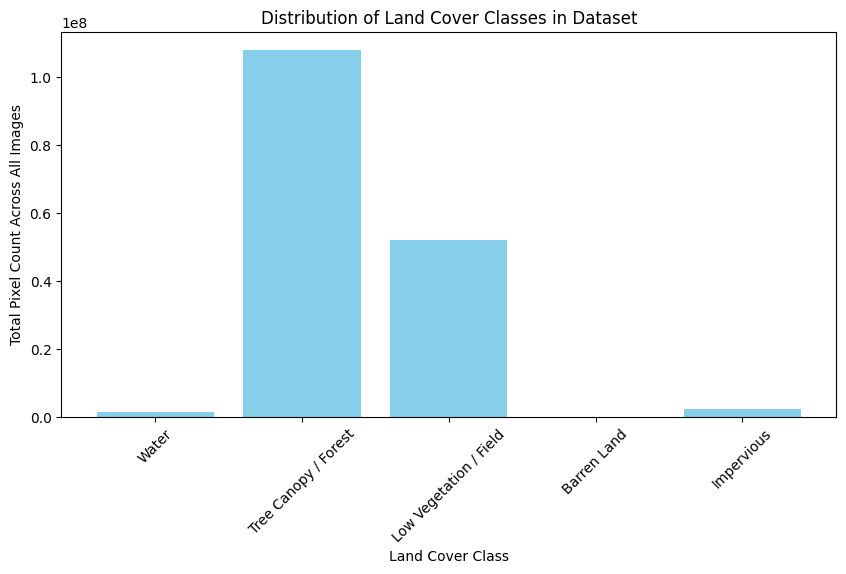

In [ ]:
# Initialize a dictionary to store class counts
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

for filename in os.listdir(dataset_path):
    if filename.endswith(".nc"):
        file_path = os.path.join(dataset_path, filename)

        dataset = xr.open_dataset(file_path)

        # Extract the land cover mask (lc)
        mask = dataset["lc"].values  # Shape: (128, 128)

        # Count occurrences of each class
        unique_classes, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique_classes, counts):
            class_counts[cls] += count

        dataset.close()

# Convert class IDs to their corresponding labels
class_labels = {
    0: 'Water',
    1: 'Tree Canopy / Forest',
    2: 'Low Vegetation / Field',
    3: 'Barren Land',
    4: 'Impervious',
    5: 'No Data'
}

#Plot the frequency of each class
class_names = [class_labels[c] for c in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Land Cover Class")
plt.ylabel("Total Pixel Count Across All Images")
plt.title("Distribution of Land Cover Classes in Dataset")
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()


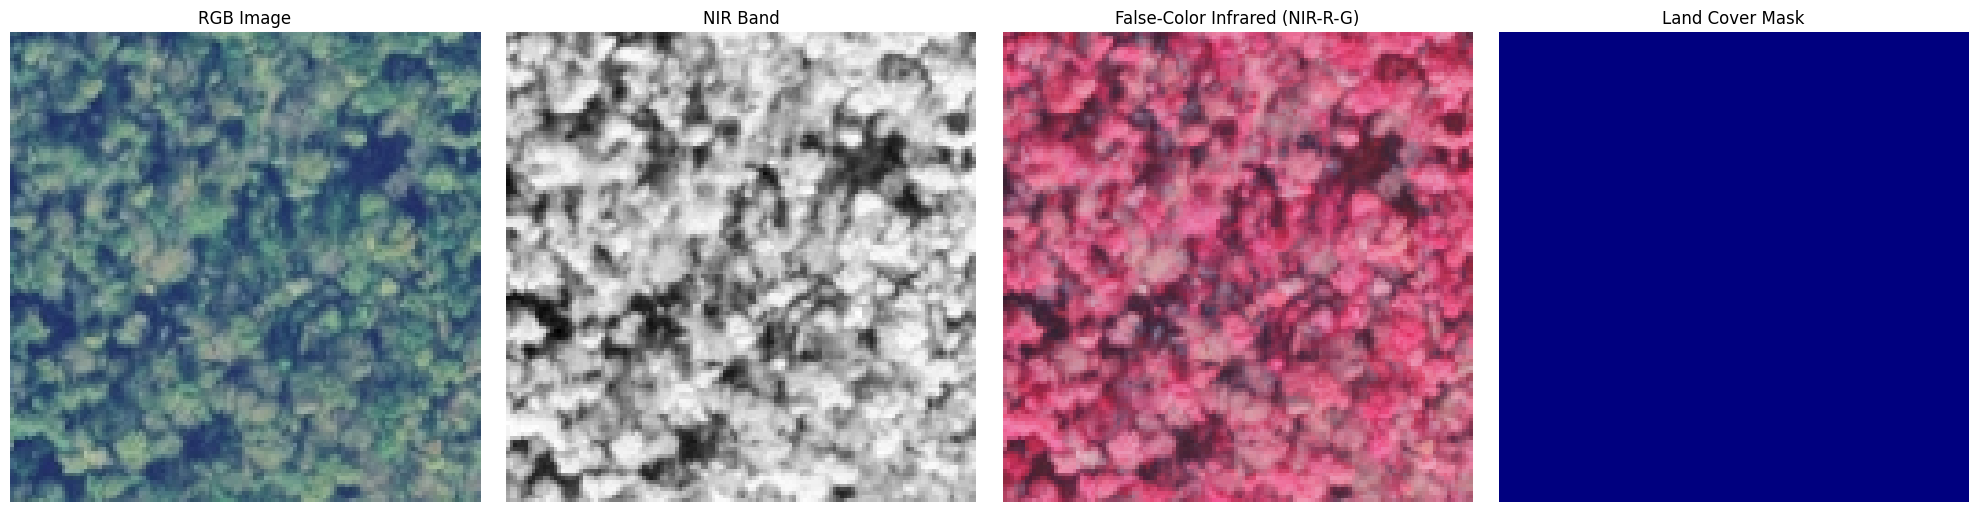

In [ ]:

mask = sample_img['lc'].values
# Extract RGB bands and convert to NumPy array
rgb_image = np.stack([
    sample_img["r"].values,
    sample_img["g"].values,
    sample_img["b"].values
], axis=-1)

# Extract NIR band
nir_image = sample_img["nir"].values

# Create False-Color Infrared (FCIR) image (NIR-R-G)
fcir_image = np.stack([
    sample_img["nir"].values,
    sample_img["r"].values,
    sample_img["g"].values
], axis=-1)

# Ensure valid ranges before conversion
rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
nir_image = np.clip(nir_image, 0, 255)
fcir_image = np.clip(fcir_image, 0, 255).astype(np.uint8)


# Create figure with 4 subplots
plt.figure(figsize=(20, 5))

# RGB Image
plt.subplot(1, 4, 1)
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")

# NIR Band (Grayscale)
plt.subplot(1, 4, 2)
plt.imshow(nir_image, cmap="gray")
plt.title("NIR Band")
plt.axis("off")

# False-Color Infrared (FCIR)
plt.subplot(1, 4, 3)
plt.imshow(fcir_image)
plt.title("False-Color Infrared (NIR-R-G)")
plt.axis("off")

# Land Cover Mask
plt.subplot(1, 4, 4)
plt.imshow(mask, cmap="jet")
plt.title("Land Cover Mask")
plt.axis("off")

# Show all plots
plt.tight_layout()
plt.show()


In [ ]:
import os
import xarray as xr
import numpy as np

dataset_path = './Dataset/lc_imgs/'
#Count nan values
nan_counts = {
    'r': [],  # Banda roja
    'g': [],  # Banda verde
    'b': [],  # Banda azul
    'nir': [] # Banda infrarroja
}

for file_name in os.listdir(dataset_path):
    if file_name.endswith('.nc'):
        file_path = os.path.join(dataset_path, file_name)

        try:
            sample_img = xr.open_dataset(file_path, engine="h5netcdf")

            for band in ['r', 'g', 'b', 'nir']:
                if band in sample_img:
                    nan_count = np.sum(np.isnan(sample_img[band].values))
                    nan_counts[band].append(nan_count)

        except Exception as e:
            print(f"Error {file_name}: {e}")


In [ ]:
 #Resumir los resultados de los NaNs por banda
for band in ['r', 'g', 'b', 'nir']:
    print(f"Band {band}:")
    print(f"  - Total NaNs: {np.sum(nan_counts[band])}")
    print(f"  - Max NaNs in a single image: {np.max(nan_counts[band])}")
    print(f"  - Min NaNs in a single image: {np.min(nan_counts[band])}")
    print("-" * 40)


Band r:
  - Total NaNs: 612
  - Max NaNs in a single image: 1
  - Min NaNs in a single image: 0
----------------------------------------
Band g:
  - Total NaNs: 630
  - Max NaNs in a single image: 1
  - Min NaNs in a single image: 0
----------------------------------------
Band b:
  - Total NaNs: 603
  - Max NaNs in a single image: 1
  - Min NaNs in a single image: 0
----------------------------------------
Band nir:
  - Total NaNs: 589
  - Max NaNs in a single image: 1
  - Min NaNs in a single image: 0
----------------------------------------


⭕ **Based on your EDA, what do you take away from this dataset?**
- The dataset consists of high-resolution images that contain RGB and NIR bands, along with geographic information. The NIR band is especially significant for vegetation analysis. The dataset includes a corresponding segmentation mask with 5 land cover categories. These categories encompass various land types such as water, vegetation, impervious surfaces, barren land, and areas marked as "no data." In the EDA, I did not find the 'no data' represented, which means good quality of the images and the masks.The dataset appears to be mostly composed of vegetation-related images, which may require careful consideration of the NIR band during model development to maximize classification accuracy.

# **4. Model training + Evaluation** ✨


In [ ]:
import os
import numpy as np
import tensorflow as tf
import xarray as xr
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from netCDF4 import Dataset


# Create a list of image paths
image_dir = './Dataset/lc_imgs/'  # Path to the folder containing your .nc files
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nc')]

# Split the data into train and test sets (80-20 split)
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Data pipeline function to load and preprocess data
def load_data_pipeline(image_paths, batch_size=8, shuffle=True):
    def _generator():
        for image_path in image_paths:
            # Open the .nc file
            img_data = xr.open_dataset(image_path, engine = "h5netcdf")

            # Extract RGB and NIR bands
            image = np.stack([
                img_data['r'].values,
                img_data['g'].values,
                img_data['b'].values,
                img_data['nir'].values
            ], axis=-1)

            # Normalize image
            image = np.nan_to_num(image, nan=0.0)
            image = (image - np.mean(image)) / (np.std(image) + 1e-8)


            # Extract the mask (lc) and one-hot encode it
            mask = img_data['lc'].values
            mask = to_categorical(mask, num_classes=5)

            yield image, mask

    # Define the output
    output_signature = (
        tf.TensorSpec(shape=(128, 128, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(128, 128, 5), dtype=tf.float32)
    )

    #Create dataset
    dataset = tf.data.Dataset.from_generator(_generator, output_signature=output_signature)


    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

#Focal loss function
def focal_loss(alpha=0.25, gamma=2):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        return tf.reduce_sum(loss, axis=-1)
    return loss

# Training and testing datasets
train_dataset = load_data_pipeline(train_paths, batch_size=8)
test_dataset = load_data_pipeline(test_paths, batch_size=8)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.map(lambda x, y: (tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.repeat()  # Ensure enough validation samples
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


 # Model definition (U-Net)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate


def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

     # Contracting Path (Encoder)
     c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
     c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
     p1 = MaxPooling2D((2, 2))(c1)

     c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
     c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
     p2 = MaxPooling2D((2, 2))(c2)

     c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
     c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

     # Expanding Path (Decoder)
     u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
     u4 = concatenate([u4, c2])
     c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
     c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

     u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
     u5 = concatenate([u5, c1])
     c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u5)
     c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

     outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c5)

     model = Model(inputs=inputs, outputs=outputs)

     return model


 # Compile
model = multi_unet_model(n_classes=5, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=4)
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

 # Train the model

steps_per_epoch = 1000
validation_steps = 200
with tf.device('/device:GPU:0'):

  history = model.fit(
      train_dataset,
      epochs=3,
      steps_per_epoch=steps_per_epoch,
      validation_data=test_dataset,
      validation_steps=validation_steps,
      verbose=1
  )



Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 511s 462ms/step - accuracy: 0.8339 - loss: 0.0422 - val_accuracy: 0.9258 - val_loss: 0.0183
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 453s 454ms/step - accuracy: 0.9200 - loss: 0.0189 - val_accuracy: 0.9273 - val_loss: 0.0171
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 415s 416ms/step - accuracy: 0.9216 - loss: 0.0182 - val_accuracy: 0.9285 - val_loss: 0.0172


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Mean IoU Score: 1.0000


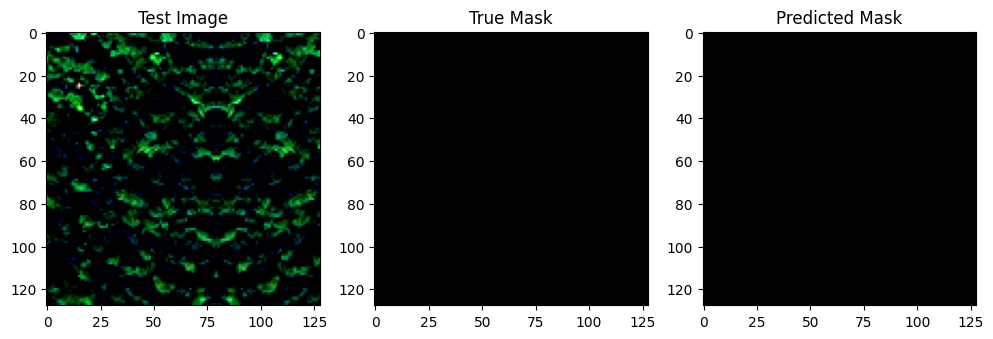

In [ ]:
from sklearn.metrics import jaccard_score

for sample in test_dataset.take(1):
    test_img = sample[0].numpy()
    true_mask = sample[1].numpy()

# Remove batch dimension
test_img = test_img[0]
true_mask = true_mask[0]

# Expand dims for prediction
test_img_input = np.expand_dims(test_img, axis=0)


y_pred = model.predict(test_img_input)
predicted_mask = np.argmax(y_pred, axis=-1)[0]
true_mask = np.argmax(true_mask, axis=-1)

#Flatten for IoU
y_true_flat = true_mask.flatten()
y_pred_flat = predicted_mask.flatten()

#IoU
iou = jaccard_score(y_true_flat, y_pred_flat, average='macro')
print(f"Mean IoU Score: {iou:.4f}")

#Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_img[:, :, :3])  # Show RGB image
plt.title("Test Image")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap="gray")  # True mask
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap="gray")  # Predicted mask
plt.title("Predicted Mask")

plt.show()


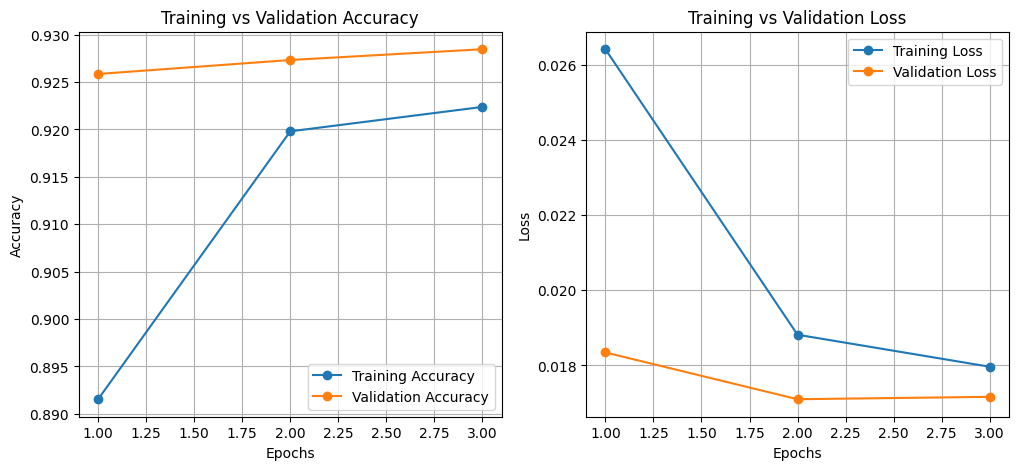

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)  # Number of epochs

# 📌 Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# 📌 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

⭕ **What was the reasoning behind your selection of metrics?**

I tried to use accuracy, loss and also IOU. These metrics are the most used in CNN models, and together can give you an idea of how the model is performing. In a class imbalanced dataset like this one, only accuracy would not be effective. IOU metric is particularly helpful in cases of class imbalance since it focuses on per-class performance.
The loss function gives insights into how well the model is learning during training. It quantifies the difference between the predicted output and the ground truth. As training progresses, the loss should decrease, indicating that the model is improving its predictions.
I also used Focal Loss as is a modified version of cross-entropy loss that down-weights easy examples and focuses more on hard-to-classify ones.


⭕ **What kind of steps would you take to improve model performance?**
First of all I would focus on performing more epochs and see how the metrics result. Then I would try to perform data augmentation for class imbalance, and see if the tuning of other hyperparameters can help (learning rate, batch size, optimizers).
⭕ **Based on the model training, what are your inferences. Use plots and data to back up your answers**
As shown in the training vs. validation accuracy plot, the model has lower training accuracy than validation accuracy wich suggests that the model generalizes well to unseen data and is not overfitting to the training data. Despite this good performance on unseen data, the model performs better on the forest class, which may be due to the higher prevalence of this class in the dataset or its distinctive features. The random image prediction plots confirm that the model tends to perform better on the forest class and struggles with other classes.
⭕ **If the landcover segmentation was to instead be done with a time series image dataset, how would you adapt your approach? (max 300 words)**
- If the land cover segmentation task were to be performed using a time-series image dataset, I would focus on models designed to handle sequential data. One approach would be to stack the image bands along with a new time variable, effectively transforming the dataset into a temporal sequence. This would allow the model to learn not only spatial but also temporal dependencies in the data, which is crucial for understanding changes over time.

